In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import random
import tqdm
import datetime
import seaborn as sns

### Download map

![Cordinates for interesting area from bboxfinder.com](bbox.png)

### Prepare data

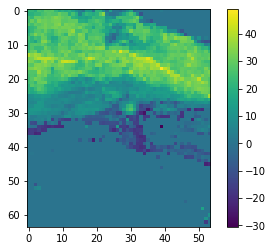

In [30]:
dBZ_radar = np.load('radar_regression.npy')

from radar import marshal_palmer
p_radar = marshal_palmer(dBZ_radar)

plt.imshow(dBZ_radar)
plt.colorbar()

In [31]:
dBZ_radar.shape

(64, 54)

### Polynomial fit and MSE

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

polynomial_degrees = np.arange(1, 30, 2)
regularization = np.array([0, 10**(-15), 10**(-9), 0.01])
train_mse = np.zeros((len(polynomial_degrees), len(regularization)))
test_mse = np.zeros((len(polynomial_degrees), len(regularization)))

z = dBZ_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

# scale data, 
# centering for making ridge regression more meningful
# dividing by variance so that values gets a lower spread, "lin alg warning from sklearn"
x = ( x - np.mean(x) ) / np.var(x)
y = ( y - np.mean(y) ) / np.var(y)
z = ( z - np.mean(z) ) / np.var(z)

k_folds = 7

xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for poly in tqdm.tqdm(range(len(polynomial_degrees))):
    for j in range(len(regularization)):
        MSE_test = []
        MSE_train = []
        for k in range(k_folds):     
            # extract folds
            xyz_test = xyz_folds[k].copy() # k-th fold is test 
            xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold
            xy_train = xyz_train[:, 0:2]
            z_train = xyz_train[:, 2].reshape(-1, 1)
            xy_test = xyz_test[:, 0:2]
            z_test = xyz_test[:, 2].reshape(-1, 1)    
    
                #Scale using train group
                #xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
                #xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
                #z_test[:] =  z_test[:] - np.mean(z_train[:]) 
                
                #xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
                #xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
                #z_train[:] =  z_train[:] - np.mean(z_train[:])
            
                
            model_skl = make_pipeline(PolynomialFeatures(degree=polynomial_degrees[poly]), 
                                      Ridge(
                                      alpha=regularization[j], 
                                      fit_intercept=False))
            
            model_skl.fit(xy_train, z_train.ravel()) 
            skl_predict_test = model_skl.predict(xy_test)
            skl_predict_train = model_skl.predict(xy_train)
            MSE_test.append( mean_squared_error(z_test.ravel(), skl_predict_test ) )
            MSE_train.append( mean_squared_error(z_train.ravel(), skl_predict_train ) )
         
        train_mse[poly, j] = np.mean(MSE_train)
        test_mse[poly, j] = np.mean(MSE_test)

 20%|█████▌                      | 3/15 [00:00<00:00, 20.25it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.39321e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.50914e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.43358e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.47629e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrit

 40%|███████████▏                | 6/15 [00:00<00:00, 12.04it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.24029e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.32811e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.21151e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.2726e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.37756e-51): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.46359e-51): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.34538e-51): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=2.42625e-51): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/s

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.29781e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.28515e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
 80%|█████████████████████▌     | 12/15 [00:02<00:00,  4.17it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.27127e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=3.2812e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite

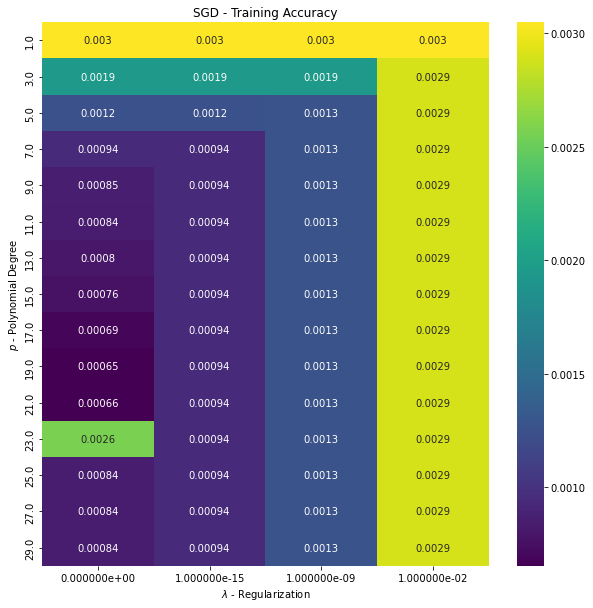

In [69]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_mse[:, :], annot=True, ax=ax, cmap="viridis")
ax.set_title("SGD - Training Accuracy")
ax.set_ylabel("$p$ - Polynomial Degree")
ax.set_xlabel("$\lambda$ - Regularization")
ax.set_xticklabels(["{:e}".format(i) for i in regularization] )
ax.set_yticklabels(["{0:0.1f}".format(i) for i in polynomial_degrees])
plt.show()

(0.0, 200.0)

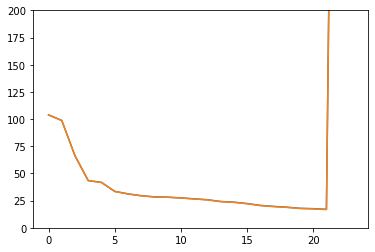

In [15]:
plt.plot(test_mse[1:, 0])
plt.plot(train_mse[1:, 0])
plt.ylim(0, 200)

# Neural Network

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

learning_rate = np.logspace(-5, 0, 3)
regularization = np.linspace(0, 0.1, 3)


hidden_layers = [[10, 10], [20, 20], [10, 10, 10], [20, 20, 20]]

train_mse_nn = np.zeros((len(hidden_layers), len(learning_rate), len(regularization)))
test_mse_nn = np.zeros((train_mse_nn.shape))

z = dBZ_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

k_folds = 7

xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for n_layers in tqdm.tqdm(range(len(hidden_layers))):
    hidden_layer_sizes = hidden_layers[n_layers] 
    for i in range(len(learning_rate)):
        for j in range(len(regularization)):
            MSE_test = []
            MSE_train = []
            for k in range(k_folds):     
                # extract folds
                xyz_test = xyz_folds[k].copy() # k-th fold is test 
                xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

                xy_train = xyz_train[:, 0:2]
                z_train = xyz_train[:, 2].reshape(-1, 1)
                xy_test = xyz_test[:, 0:2]
                z_test = xyz_test[:, 2].reshape(-1, 1)    
    
                #Scale groups using train mean and std
                #xy_test[:, 0] =  xy_test[:, 0] - np.mean(xy_train[:, 0]) 
                #xy_test[:, 1] =  xy_test[:, 1] - np.mean(xy_train[:, 1])
                #z_test[:] =  z_test[:] - np.mean(z_train[:]) 
                #xy_train[:, 0] =  xy_train[:, 0] - np.mean(xy_train[:, 0])  
                #xy_train[:, 1] =  xy_train[:, 1] - np.mean(xy_train[:, 1])
                #z_train[:] =  z_train[:] - np.mean(z_train[:])

                dnn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                                   activation='logistic',
                                   solver='adam',
                                   alpha=regularization[j], 
                                   learning_rate_init=learning_rate[i], 
                                   max_iter=1000)
                
                dnn.fit(xy_train, z_train.ravel())
            
                dnn_zpred_train = dnn.predict(xy_train)
                dnn_zpred_test = dnn.predict(xy_test)            
            
                MSE_test.append( mean_squared_error(z_test.ravel(), dnn_zpred_test ) )
                MSE_train.append( mean_squared_error(z_train.ravel(), dnn_zpred_train ) )
            
            
            train_mse_nn[n_layers, i, j] = np.mean(MSE_train)
            test_mse_nn[n_layers, i, j] = np.mean(MSE_test)

  0%|                                     | 0/4 [00:00<?, ?it/s]/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't conv

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8

/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/erlend/anaconda3/lib/python3.8

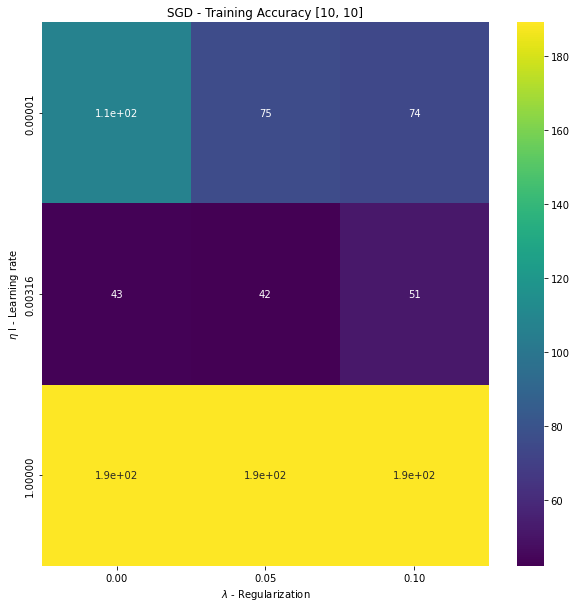

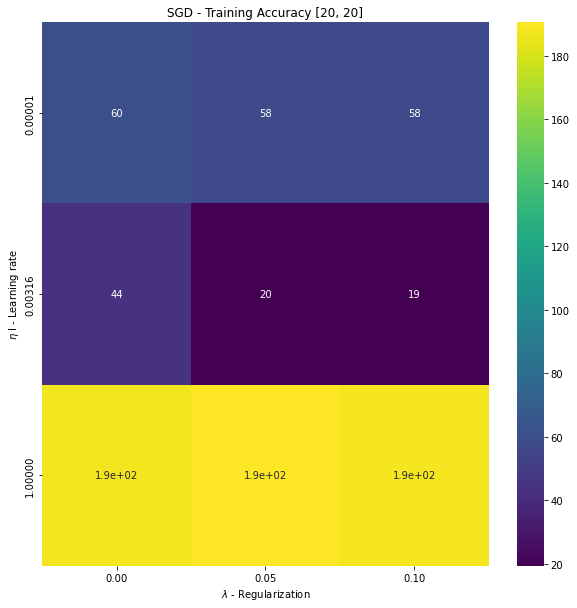

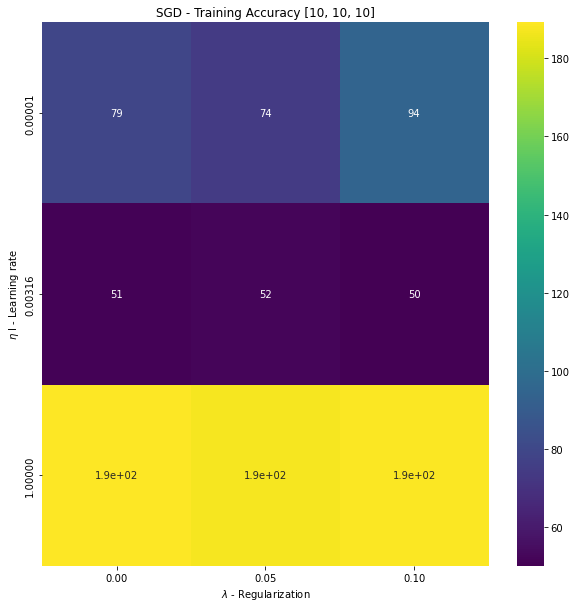

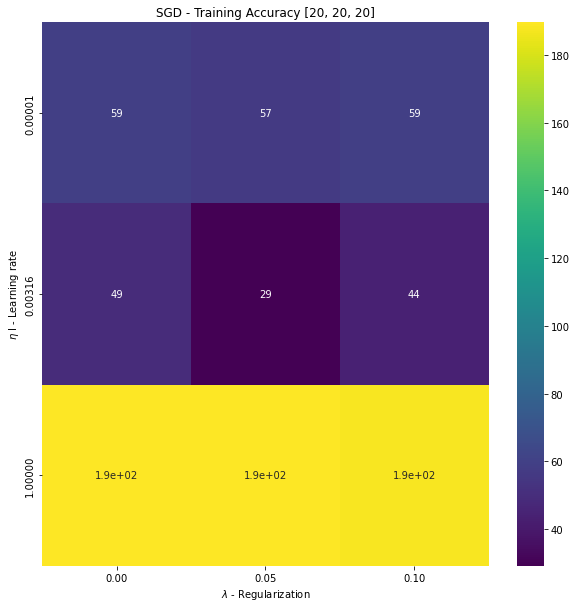

In [12]:
for layer in range(len(hidden_layers)):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_mse_nn[layer, :, :], annot=True, ax=ax, cmap="viridis")
    ax.set_title("SGD - Training Accuracy "+ str(hidden_layers[layer]))
    ax.set_ylabel("$\eta$ l - Learning rate")
    ax.set_xlabel("$\lambda$ - Regularization")
    ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
    ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
    plt.show()

# Decision Tree

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

leafs_max = 8
train_mse_dt = np.zeros([ leafs_max ])
test_mse_dt = np.zeros([ leafs_max ])

z = dBZ_radar
x = np.arange(z.shape[1])
y = np.arange(z.shape[0])
x, y = np.meshgrid(x, y)

# scale data 
x =  x - np.mean(x) 
y =  y - np.mean(y)
z =  z - np.mean(z) 

k_folds = 7
xyz_shuffle = np.hstack([x.reshape(-1,1), y.reshape(-1,1), z.reshape(-1,1)])
np.random.shuffle(xyz_shuffle) # shuffle along axis 0
xyz_folds = np.array_split(xyz_shuffle, k_folds)

for leafs in tqdm.tqdm(range(0, leafs_max) ):
    MSE_test = []
    MSE_train = []
    for k in range(k_folds):     
        # extract folds
        xyz_test = xyz_folds[k].copy() # k-th fold is test 
        xyz_train = np.vstack([xyz_folds[f] for f in range(k_folds) if f != k]).copy() # skip k-th fold

        xy_train = xyz_train[:, 0:2]
        z_train = xyz_train[:, 2].reshape(-1, 1)
        xy_test = xyz_test[:, 0:2]
        z_test = xyz_test[:, 2].reshape(-1, 1)               
            
        clf1 = DecisionTreeClassifier(min_samples_leaf=leafs, random_state=42)
        clf1.fit(xy_train, z_train)

        skl_predict_test = clf1.predict(xy_test)
        skl_predict_train = clf1.predict(xy_train)
        MSE_test.append( mean_squared_error(z_test.ravel(), skl_predict_test ) )
        MSE_train.append( mean_squared_error(z_train.ravel(), skl_predict_train ) )
            
    train_mse_dt[leafs] = np.mean(MSE_train)
    test_mse_dt[leafs] = np.mean(MSE_test)

  0%|                                     | 0/8 [00:00<?, ?it/s]


ValueError: Unknown label type: 'continuous'

In [ ]:
for leaf in range(0, leafs_max):
    fig, ax = plt.subplots(figsize = (10, 10))
    sns.heatmap(test_mse_dt[leaf, :, :], annot=True, ax=ax, cmap="viridis")
    ax.set_title("SGD - Training Accuracy")
    ax.set_ylabel("$\eta$ l - Learning rate")
    ax.set_xlabel("$\lambda$ - Regularization")
    ax.set_xticklabels(["{0:0.2f}".format(i) for i in regularization] )
    ax.set_yticklabels(["{0:0.5f}".format(i) for i in learning_rate] )
    plt.show()